In [1]:
import numpy as np
import torch
import pandas as pd
from IPython.display import Audio
import seaborn as sns
import tqdm
from sklearn.model_selection import train_test_split


from torch.utils.data import Dataset, DataLoader
sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
import utils
import models
import trainer

In [3]:
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
#     hop_length = 694*duration
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration
    trim_long_data = False

In [4]:
conf.columns, conf.column_encoder = utils.read_columns()

In [5]:
# all_x, all_y, _ = torch.load("./train_curated_preprocessed.tc")
all_x, all_y, _ = utils.read_dataset("./data/train_curated", conf, lambda s: s)

100%|██████████| 4970/4970 [00:42<00:00, 98.98it/s] 


In [6]:
all_rooms_meta, all_rooms = utils.read_filters("./filters/", conf, lambda s: s)

100%|██████████| 73/73 [00:05<00:00, 12.10it/s]


In [7]:
np.random.seed(42)
train_x, test_x, train_y, test_y = train_test_split(all_x, all_y, test_size=0.1)

In [8]:
test_x = list(map(lambda s: utils.trim_and_mel(conf, s), test_x))

In [9]:
train_dataset = trainer.SoundAugDataset(train_x, train_y, 
                                        transform = lambda s: utils.audio_to_melspectrogram(conf, s),
                                        room_filters=all_rooms[:3], 
                                        params={
                                                    "max_size":10000,
                                                    "max_n_mixed":2,
#                                                     "change_pitch":0.1,
#                                                     "change_pitch_max":1,
                                                    "add_echo":0.5,
#                                                     "harmonic_percussive":0.1,
#                                                     "noise_magnitude":0.00005
                                               },
                                        config=conf,
                                        seed=42)
test_dataset = trainer.SoundDataset(test_x, test_y)

In [10]:
aug_coll = trainer.AugmentationCollator(conf, None)
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=aug_coll, shuffle=True, num_workers=0)

In [11]:
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=trainer.collate_fn, shuffle=True)

In [12]:
device = torch.device("cuda")
# model = models.Net(128, all_x[0].shape[-1], 80)
model = models.LSTMModel(128, 80)
model = model.to(device)

In [13]:
def optimizer_factory(params):
    result = torch.optim.Adam(params, lr=1e-3)
    return result
    
def scheduler_factory(optimizer):
    result = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)
    return result

In [14]:
tr = trainer.Trainer(model, optimizer_factory, scheduler_factory, device, {"path":"./experiments/lstm/"})

In [ ]:
tr.train(
    loaders={"train_loader":train_loader, "test_loader":test_loader},
    params={"epochs":50, "grad_clip_norm":10.0, "validate_every":25},
)

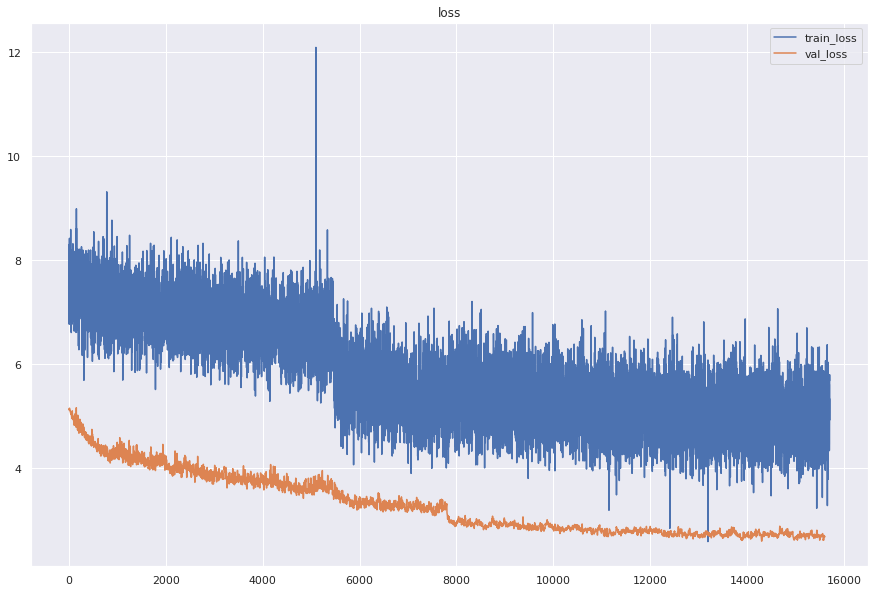

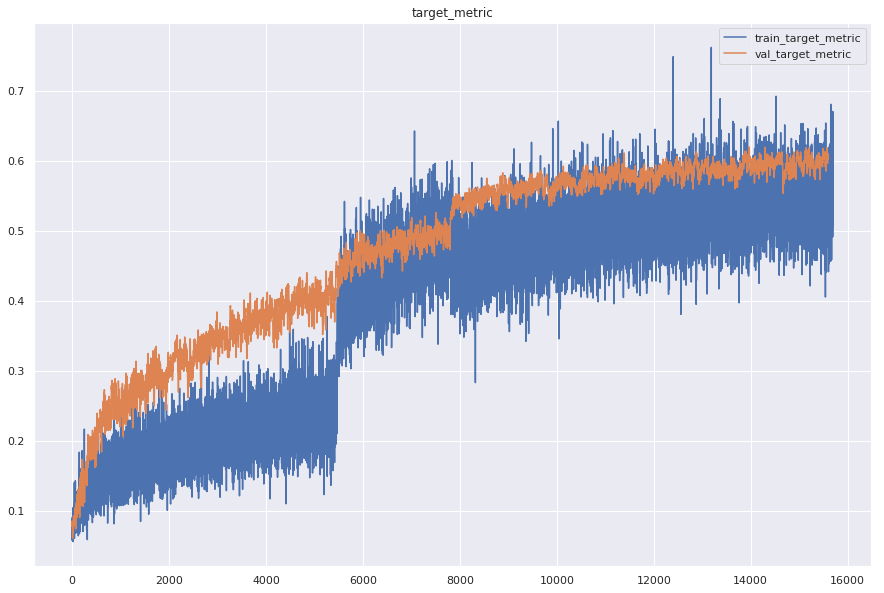

In [17]:
tr.plot(tr.train_metrics, tr.val_metrics)

In [18]:
tr.save_path

'./experiments/lstm/2019-06-16.10.02.07'

In [139]:
min(tr.val_metrics['loss']), tr.val_metrics['loss'][-100:]

(3.1275942052154235,
 [3.3085397402765286,
  3.335505795430849,
  3.3610374951506525,
  3.4154749660184924,
  3.422264501602357,
  3.4259441474553807,
  3.4060084599124596,
  3.389508011835202,
  3.3530517391995405,
  3.3362154130724595,
  3.332209525213875,
  3.3255766416699353,
  3.3306170287026724,
  3.347744757020977,
  3.3688455069328938,
  3.3859260096636334,
  3.40350126356666,
  3.4086292706265056,
  3.4184397351094176,
  3.4407323020804577,
  3.4545909355823663,
  3.4639170289759185,
  3.4738299405310955,
  3.482814123453029,
  3.476821247001049,
  3.4454231468484675,
  3.4199830670232023,
  3.3627929745065854,
  3.3420246789153194,
  3.339990189857406,
  3.346827721931565,
  3.364646396886415,
  3.387663641685931,
  3.3902601289077543,
  3.386154896776441,
  3.3614081007613983,
  3.3602946337080097,
  3.3645704881526095,
  3.371495175409605,
  3.3949165795170804,
  3.405764680992909,
  3.412461485181536,
  3.4331753896755473,
  3.4387689999171664,
  3.442532747084466,
  3.430

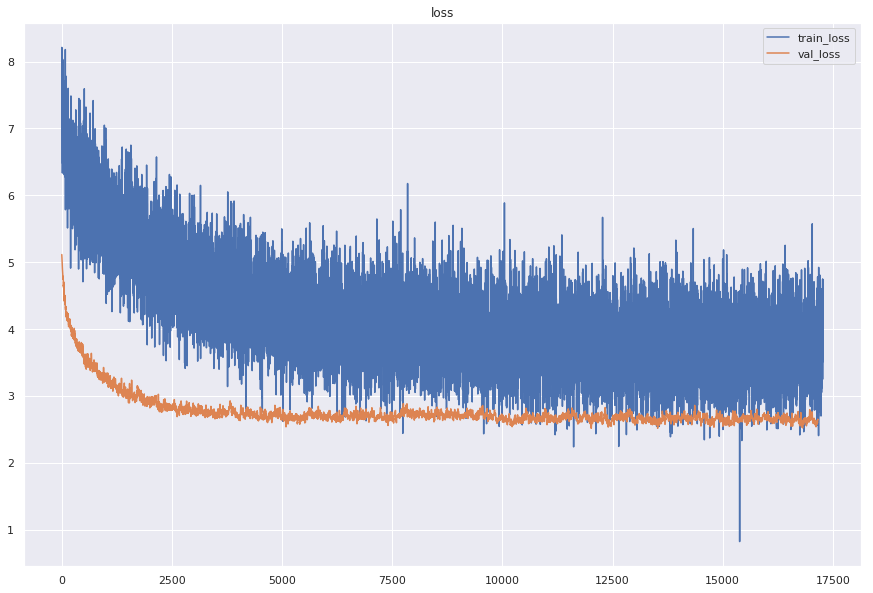

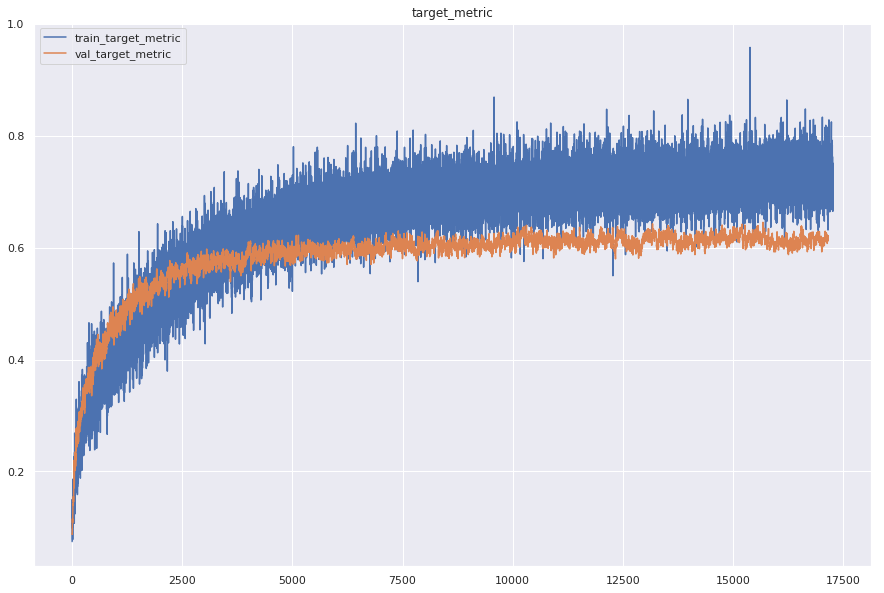

In [26]:
tr.plot(tr.train_metrics, tr.val_metrics)